### Visualize HR data from exercise sessions

In [11]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
def _extract_sessions(payload: dict):

    sessions = []

    if isinstance(payload.get("session"), dict):
        sessions.append(payload["session"])

    if isinstance(payload.get("sessions"), list):
        sessions.extend([s for s in payload["sessions"] if isinstance(s, dict)])

    # If nothing matched, try: maybe file is already a session dict
    if not sessions and ("meta" in payload and "samples" in payload):
        sessions.append(payload)

    return sessions

In [13]:
def load_hr_dataframe(json_path):
    # Convert input to Path 
    json_path = Path(json_path)

    # Read and parse JSON file
    payload = json.loads(json_path.read_text(encoding = "utf-8"))

    # Try to get client name from JSON (supports {"client":{"name":...}} or {"name":...})
    client_name = None
    if isinstance(payload.get("client"), dict):
        client_name = payload["client"].get("name")
    if not client_name:
        client_name = payload.get("name")

    # Get the exercise label from the filename
    exercise = json_path.name.split("_", 1)[1].rsplit(".", 1)[0] if "_" in json_path.name else json_path.stem

    # Extract sessions 
    sessions = payload.get("sessions")
    if not isinstance(sessions, list):
        sessions = [payload]

    results = []

    for sess in sessions:
        meta = sess.get("meta") or {}
        samples = sess.get("samples") or []

        # Skip if no samples
        if not isinstance(samples, list) or len(samples) == 0:
            continue

        # Build DataFrame
        df = pd.DataFrame(samples)

        # Ensure the columns exist
        for col in ["tsMs", "heartRate", "batteryPercent"]:
            if col not in df.columns:
                df[col] = pd.NA

        # Clean/sort timestamps
        df["tsMs"] = pd.to_numeric(df["tsMs"], errors = "coerce")
        df = df.dropna(subset=["tsMs"]).sort_values("tsMs").reset_index(drop=True)

        # Time columns (absolute + relative)
        df["t"] = pd.to_datetime(df["tsMs"], unit = "ms")
        df["t_rel_s"] = (df["tsMs"] - df["tsMs"].iloc[0]) / 1000.0

        # Heart rate numeric
        df["heartRate"] = pd.to_numeric(df["heartRate"], errors = "coerce")
        # Label: "<name> - <exercise>" (derived from file + JSON as you asked)
        label = f"{client_name or json_path.stem} - {exercise}"

        results.append((label, df, meta))

    return results

In [14]:
def duration_of_session(df: pd.DataFrame) -> dict:

    duration_s = float(df["t_rel_s"].iloc[-1]) if "t_rel_s" in df.columns else 0.0
    return {
        "duration_s": duration_s,
        "duration_min": duration_s / 60.0,
    }

In [15]:
def plot_hr(df: pd.DataFrame, info: str, use_relative_time: bool = True):

    hr = df["heartRate"]
    x = df["t_rel_s"]

    plt.figure(figsize=(10, 4))
    plt.plot(x, hr, linewidth = 1)

    plt.ylabel("Heart Rate (bpm)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Info:", info)
    print("Duration of session:", duration_of_session(df))


In [16]:
files = [
    "/Users/rosalouisemarker/sessions/olivia_reformer.json",
    "/Users/rosalouisemarker/sessions/rosa_hotabsolution.json",
    "/Users/rosalouisemarker/sessions/rosa_hotpilates.json",
    "/Users/rosalouisemarker/sessions/rosa_reformergravitystrength.json",
]


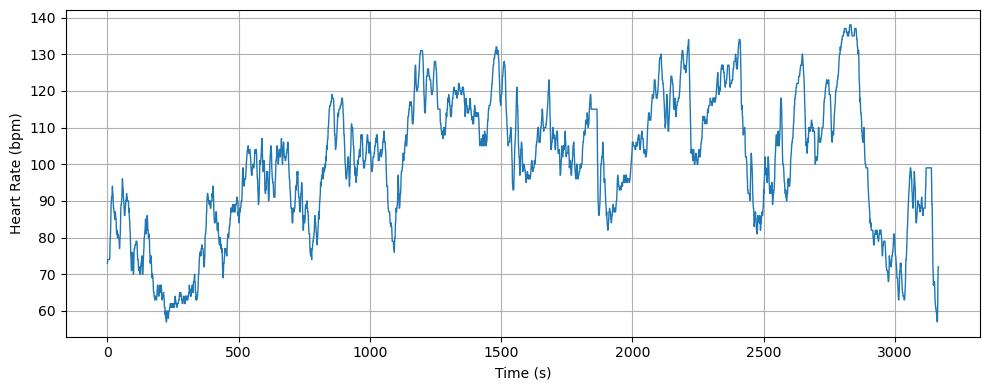

Info: olivia_reformer.json - Olivia Johanneson - reformer
Duration of session: {'duration_s': 3165.973, 'duration_min': 52.766216666666665}


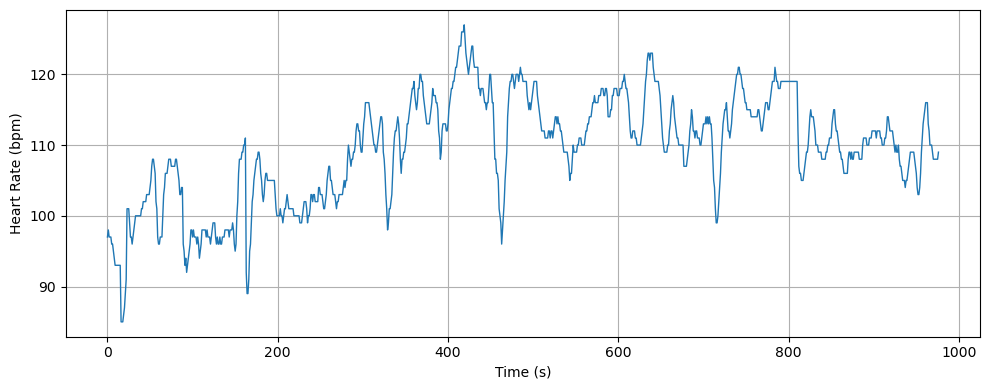

Info: rosa_hotabsolution.json - Rosa Marker - hotabsolution
Duration of session: {'duration_s': 976.0, 'duration_min': 16.266666666666666}


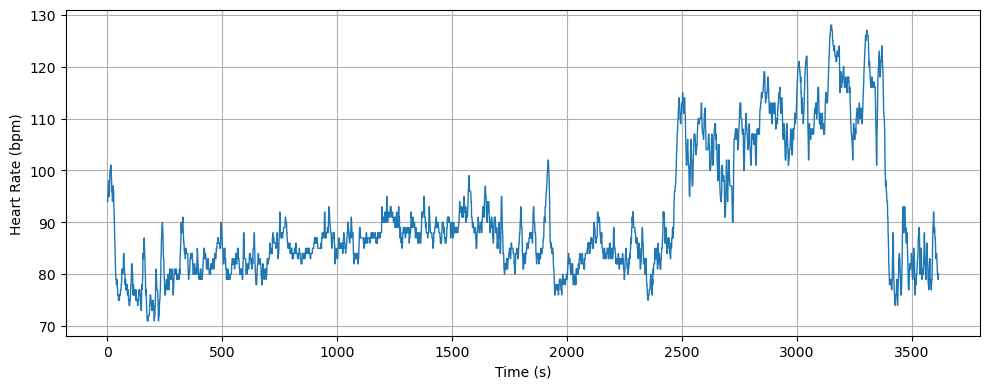

Info: rosa_hotpilates.json - Rosa Marker - hotpilates
Duration of session: {'duration_s': 3614.96, 'duration_min': 60.24933333333333}


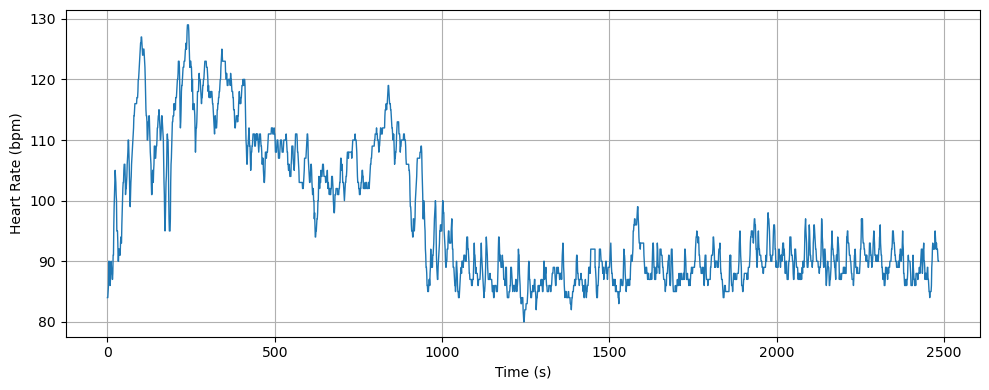

Info: rosa_reformergravitystrength.json - Rosa Marker - reformergravitystrength
Duration of session: {'duration_s': 2482.981, 'duration_min': 41.38301666666667}


In [17]:
for f in files:
    sessions = load_hr_dataframe(f)
    if not sessions:
        print(f"[WARN] No sessions found in: {f}")
        continue

    for label, df, meta in sessions:
        plot_hr(df, info=f"{Path(f).name} - {label}", use_relative_time = True)

In [18]:
THRESHOLDS = [110, 120, 130]
P_LOW, P_HIGH = 5, 95

In [ ]:
def summarize_hr(df: pd.DataFrame, label: str) -> dict:
    hr = pd.to_numeric(df["heartRate"], errors = "coerce").dropna()

    duration_s = float(df["t_rel_s"].iloc[-1]) if "t_rel_s" in df.columns and len(df) > 1 else 0.0
    duration_min = duration_s / 60.0
    n = int(hr.shape[0])

    out = {
        "class": label,
        "duration_min": duration_min,
        "samples_n": n,
        "mean_bpm": float(hr.mean()) if n else np.nan,
        "median_bpm": float(hr.median()) if n else np.nan,
        "sd_bpm": float(hr.std(ddof = 1)) if n > 1 else np.nan,
        "min_bpm": float(hr.min()) if n else np.nan,
        "max_bpm": float(hr.max()) if n else np.nan,
        f"p{P_LOW}_bpm": float(np.percentile(hr, P_LOW)) if n else np.nan,
        f"p{P_HIGH}_bpm": float(np.percentile(hr, P_HIGH)) if n else np.nan,
    }

    for th in THRESHOLDS:
        out[f"ge_{th}_pct"] = float((hr >= th).mean() * 100.0) if n else np.nan

    return out

In [20]:
def hr_zones(df: pd.DataFrame, label: str) -> pd.Series:
    hr = pd.to_numeric(df["heartRate"], errors = "coerce").dropna()
    hr = hr[(hr >= 30) & (hr <= 240)]

    bins = [0, 110, 120, 130, np.inf]
    zone_names = ["<110", "110-119", "120-129", ">=130"]

    zones = pd.cut(hr, bins = bins, right = False, labels = zone_names)
    pct = (zones.value_counts(normalize = True) * 100.0).reindex(zone_names).fillna(0.0)
    pct.name = label
    return pct

In [21]:
all_sessions = []

for f in files:
    sessions = load_hr_dataframe(f)
    if not sessions:
        print(f"[WARN] No sessions found in: {f}")
        continue

    for label, df, meta in sessions:
        all_sessions.append((Path(f).name, label, df, meta))

print("Loaded sessions:", len(all_sessions))

Loaded sessions: 4


In [22]:
summary_rows = []
for file_name, label, df, meta in all_sessions:
    summary_rows.append(summarize_hr(df, label))

summary_df = pd.DataFrame(summary_rows)

# Round for readability
round_cols_1 = ["duration_min", "mean_bpm", "median_bpm", "sd_bpm", "ge_110_pct", "ge_120_pct", "ge_130_pct"]
for c in round_cols_1:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].round(1)

round_cols_0 = ["min_bpm", "max_bpm", f"p{P_LOW}_bpm", f"p{P_HIGH}_bpm"]
for c in round_cols_0:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].round(0)

summary_df = summary_df.sort_values("mean_bpm", ascending = False).reset_index(drop = True)
summary_df

,class,duration_min,samples_n,mean_bpm,median_bpm,sd_bpm,min_bpm,max_bpm,p5_bpm,p95_bpm,ge_110_pct,ge_120_pct,ge_130_pct
0,Rosa Marker - hotabsolution,16.3,977,109.4,110.0,7.5,85.0,127.0,96.0,120.0,53.9,6.1,0.0
1,Olivia Johanneson - reformer,52.8,3167,100.3,102.0,18.1,57.0,138.0,65.0,128.0,32.1,14.9,4.0
2,Rosa Marker - reformergravitystrength,41.4,2473,96.8,92.0,11.3,80.0,129.0,85.0,119.0,18.6,4.5,0.0
3,Rosa Marker - hotpilates,60.2,3616,91.2,87.0,12.4,71.0,128.0,77.0,117.0,12.9,3.0,0.0
